In [315]:
import numpy as np 
from math import pi
import matplotlib.pyplot as plt 
from scipy import special

In [316]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.randn(N_train, 1)
    y_train = f(x_train)
    
    x_validation = np.random.randn(N_train, 1)
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    y_test = f(x_test)
    
    #plt.plot(x_test, y_test)
    #plt.title('y_test')
    #plt.show()
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test 

In [317]:
def func_min(x, y, d, w0, px): 
    
    N = len(x)
    
    dx = x[1] - x[0]
    # E_y = np.sum(px * y * dx)
    # fp = np.sqrt(px) * (y - E_y)
    fp = np.sqrt(px) * (y - np.mean(y)) / px
    #print(fp)
    
    if d==1: 
        temp = np.transpose(x)
        temp = np.tile(temp, (N, 1))
        diff = temp - np.transpose(temp)
        snc = np.sinc(w0 * diff / np.pi)
    else: 
        snc = np.ones((N, N))
        for i in np.arange(0,d): 
            temp = np.tile(x**i, (N, 1))
            diff = temp - np.transpose(temp)
            snc *= np.sinc(w0 * diff / np.pi)
    #print(snc)
    
    f = 1 / N**2 * (w0/np.pi)**d * np.transpose(fp).dot(snc).dot(fp) 
    
    return f

In [318]:
def method_2_w0(x, y, guess1, guess2, px): 
    # define the function includes w0

    d = 1
    y2 = y.mean(axis=1).reshape(len(y), 1)
    w0 = np.array([guess1, guess2]) 
    f = np.array([func_min(x, y, d, w0[0], px), func_min(x, y, d, w0[1], px)])
    y_var = np.var(y)
    f = f / y_var - 1/2

    while np.abs(f[-1]) > 1e-4: 
        w0_temp = w0[-1] - f[-1] * (w0[-1] - w0[-2]) / (f[-1] - f[-2])
        w0 = np.append(w0, w0_temp)
        f = np.append(f, func_min(x, y, d, w0_temp, px)/ y_var - 1/2)
        
    w0 = w0[-1]

    return w0 

In [319]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)
x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data(N_train, N_test)

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

# px = stats.norm.pdf(x_test, loc=0, scale=1) # write the  function 
px = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * (((x_test) / x_std) ** 2))
px_train = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_train / x_std) ** 2))
px_validation = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_validation / x_std) ** 2))

d = 1

w0 = method_2_w0(x_train, y_train, 1, 2,  px_train)
print(w0)

2.2475514508969026


In [320]:
def method_2(x, y, pred, w0, px):
    
    N = len(x)
    d = 1
    r = y - pred
    y_var = np.var(y)

    # calculate r_p
    rp = np.sqrt(px) * (r - np.mean(r))

    # compute sum_low
    r_sum = func_min(x, r, d, w0, px)
    
    e_low = r_sum / y_var 
    
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f
    e_high = FVU - e_low
    
    SB = (e_high - e_low) / (e_high + e_low) 
    # print(SB)
    
    return SB

In [321]:
def FVU_compute(y, pred): 
    r = y - pred 
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f 
    return FVU 

In [322]:
# training the function with NN  

import tensorflow as tf 
from tensorflow import keras 

In [323]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, 
                          hidden_layer_1,
                          hidden_layer_2, 
                          hidden_layer_3, 
                          hidden_layer_4, 
                          hidden_layer_5, 
                          output_layer])


# compling the model 
adam = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mse')

In [324]:
tf.random.set_seed(seed)
beta = model.fit(x_train, y_train, epochs=10, batch_size=32)

x_norm = (x_validation - x_mean)/x_std
pred = model.predict(x_norm)
pred = pred * y_std + y_mean
pred = np.reshape(pred, (N_train, 1))

SB = method_2(x_validation, y_validation, pred, w0, px_validation)
print(SB)
SB[0, 0]

Epoch 1/10
128/128 [==============================] - 0s 776us/step - loss: 0.3426
Epoch 2/10
128/128 [==============================] - 0s 772us/step - loss: 0.0039
Epoch 3/10
128/128 [==============================] - 0s 773us/step - loss: 0.0020
Epoch 4/10
128/128 [==============================] - 0s 781us/step - loss: 0.0021
Epoch 5/10
128/128 [==============================] - 0s 801us/step - loss: 0.0019
Epoch 6/10
128/128 [==============================] - 0s 798us/step - loss: 0.0015
Epoch 7/10
128/128 [==============================] - 0s 781us/step - loss: 0.0029
Epoch 8/10
128/128 [==============================] - 0s 792us/step - loss: 0.0045
Epoch 9/10
128/128 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 10/10
128/128 [==============================] - 0s 772us/step - loss: 0.0030
[[0.45782625]]


0.4578262506910452

In [325]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        

        # predicting the data
        x_norm = (x_validation - x_mean)/x_std
        pred = model.predict(x_norm)
        pred = pred * y_std + y_mean
        pred = np.reshape(pred, (N_train, 1))

        FVU = FVU_compute(y_train, pred)
        SB = method_2(x_validation, y_validation, pred, w0, px_validation)
        print(SB)
        
        i = int(epoch - 1)
        FVU_list[i] = FVU
        SB_list[i] = SB[0,0]
        
        #print(SB)

In [326]:
N_epoch = 10
FVU_list = np.zeros(N_epoch)
SB_list = np.zeros(N_epoch)

SB_callback = Compute_SB_Callback()
tf.random.set_seed(seed)
beta = model.fit(x_train, y_train, epochs=N_epoch, batch_size=32, callbacks=[SB_callback])

my_loss = beta.history['loss']

Epoch 1/10
128/128 [==============================] - 1s 6ms/step - loss: 0.0010
Epoch 2/10
128/128 [==============================] - 1s 6ms/step - loss: 9.7699e-04
Epoch 3/10
128/128 [==============================] - 1s 6ms/step - loss: 0.0014
Epoch 4/10
128/128 [==============================] - 1s 6ms/step - loss: 6.9094e-04
Epoch 5/10
128/128 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 6/10
128/128 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 7/10
128/128 [==============================] - 1s 7ms/step - loss: 0.0018
Epoch 8/10
128/128 [==============================] - 1s 8ms/step - loss: 6.2139e-04
Epoch 9/10
128/128 [==============================] - 1s 6ms/step - loss: 7.2218e-04
Epoch 10/10
128/128 [==============================] - 1s 6ms/step - loss: 6.4227e-04


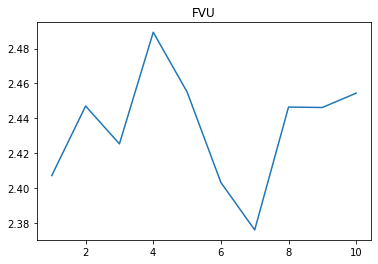

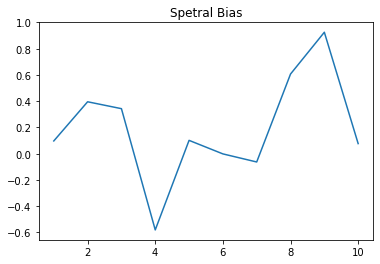

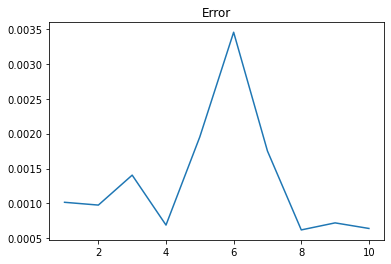

In [327]:
epoch_list = np.arange(1, N_epoch+1)

plt.plot(epoch_list, FVU_list)
#plt.ylim(0,1)
plt.title('FVU')
plt.show()

plt.plot(epoch_list, SB_list)
plt.title('Spetral Bias')
plt.show()

plt.plot(epoch_list, my_loss)
plt.title('Error')
#plt.ylim(0,0.05)
plt.show()